# Preparing

In [15]:
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [16]:
# ---- Load cleaned train set (no ID) ----
data_path = Path("cup25_train_clean.csv")  # adjust if needed
df = pd.read_csv(data_path)

# Inputs and targets
X = df[[f"x{i}" for i in range(1, 13)]].to_numpy()   # 12 inputs
y = df[[f"y{i}" for i in range(1, 5)]].to_numpy()    # 4 targets

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (500, 12) y shape: (500, 4)


In [17]:
# 2. Split internal test 15% (fixed random_state)
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Dev (85%) :", X_dev.shape, y_dev.shape)
print("Test (15%):", X_test.shape, y_test.shape)

Dev (85%) : (400, 12) (400, 4)
Test (15%): (100, 12) (100, 4)


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def make_pipe(model):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=4, random_state=42)),
        ("model", model),
    ])

# KNN

In [20]:
def mee(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Expect multi-output with 4 targets
    if y_true.ndim != 2 or y_pred.ndim != 2:
        raise ValueError(f"Expected 2D arrays. Got y_true.ndim={y_true.ndim}, y_pred.ndim={y_pred.ndim}")
    if y_true.shape[1] != 4 or y_pred.shape[1] != 4:
        raise ValueError(f"Expected 4 outputs. Got y_true.shape={y_true.shape}, y_pred.shape={y_pred.shape}")

    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))


## Elbow

In [21]:
def elbow_max_distance(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # normalize to [0,1] to reduce scale bias
    x_n = (x - x.min()) / (x.max() - x.min() + 1e-12)
    y_n = (y - y.min()) / (y.max() - y.min() + 1e-12)

    x1, y1 = x_n[0], y_n[0]
    x2, y2 = x_n[-1], y_n[-1]

    A = y1 - y2
    B = x2 - x1
    C = x1*y2 - x2*y1

    denom = np.sqrt(A*A + B*B) + 1e-12
    dist = np.abs(A*x_n + B*y_n + C) / denom

    return int(np.argmax(dist))


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt

neg_mee = make_scorer(mee, greater_is_better=False)

def knn_cv_elbow_plot(X_dev, y_dev,
                     neighbors_grid=(1,2,3,5,7,9,11,15,21,31,41,51),
                     weights="distance", p=2,
                     pca_components=4,
                     n_splits=5, n_repeats=3, random_state=42):

    neighbors_grid = np.array(list(neighbors_grid), dtype=int)

    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    train_mean, train_std = [], []
    val_mean, val_std = [], []

    for k in neighbors_grid:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=pca_components, random_state=random_state)),
            ("knn", KNeighborsRegressor(n_neighbors=k, weights=weights, p=p))
        ])

        out = cross_validate(
            pipe, X_dev, y_dev,
            scoring=neg_mee,
            cv=cv,
            return_train_score=True,
            n_jobs=-1
        )

        tr = -out["train_score"]
        va = -out["test_score"]

        train_mean.append(tr.mean()); train_std.append(tr.std())
        val_mean.append(va.mean());   val_std.append(va.std())

    train_mean = np.array(train_mean); train_std = np.array(train_std)
    val_mean   = np.array(val_mean);   val_std   = np.array(val_std)

    # 1) best k by minimum CV mean
    i_min = int(np.argmin(val_mean))
    k_min = int(neighbors_grid[i_min])

    # 2) 1-SE rule
    thresh = val_mean[i_min] + val_std[i_min]
    eligible = np.where(val_mean <= thresh)[0]
    i_1se = int(eligible[-1])
    k_1se = int(neighbors_grid[i_1se])

    # 3) elbow on prefix up to k_min
    prefix_idx = np.arange(0, i_min + 1)
    x_pref = neighbors_grid[prefix_idx]
    y_pref = val_mean[prefix_idx]
    i_elb_local = elbow_max_distance(x_pref, y_pref)
    i_elb = int(prefix_idx[i_elb_local])
    k_elbow = int(neighbors_grid[i_elb])

    # ---- plot ----
    fig, ax = plt.subplots()

    ax.errorbar(neighbors_grid, train_mean, yerr=train_std, marker="o", capsize=3, label="Train (CV mean ± std)")
    ax.errorbar(neighbors_grid, val_mean,   yerr=val_std,   marker="o", capsize=3, label="Validation (CV mean ± std)")

    ax.axvline(k_elbow, linestyle="--", linewidth=1)
    ax.axvline(k_min,   linestyle="--", linewidth=1)
    ax.axvline(k_1se,   linestyle="--", linewidth=1)

    y_top = ax.get_ylim()[1]
    ax.text(k_elbow, y_top, f" elbow={k_elbow}", va="top")
    ax.text(k_min,   y_top, f" min={k_min}",   va="top")
    ax.text(k_1se,   y_top, f" 1se={k_1se}",   va="top")

    ax.set_xlabel("k (number of neighbors)")
    ax.set_ylabel("MEE")
    ax.set_title(f"KNN + Scaler + PCA({pca_components}) | weights={weights}, p={p} | CV={n_splits}x{n_repeats}")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return {
        "neighbors": neighbors_grid,
        "train_mean": train_mean, "train_std": train_std,
        "val_mean": val_mean, "val_std": val_std,
        "k_elbow": k_elbow,
        "k_min": k_min,
        "k_1se": k_1se,
        "threshold_1se": float(thresh),
    }


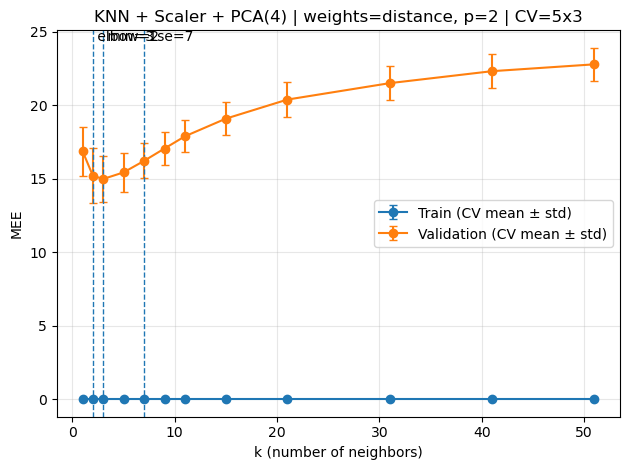

k_elbow: 2
k_min  : 3
k_1se  : 7


In [10]:
result = knn_cv_elbow_plot(
    X_dev, y_dev,
    neighbors_grid=(1,2,3,5,7,9,11,15,21,31,41,51),
    weights="distance",
    p=2,
    pca_components=4,
    n_splits=5,
    n_repeats=3
)

print("k_elbow:", result["k_elbow"])
print("k_min  :", result["k_min"])
print("k_1se  :", result["k_1se"])

## Degree of freedom

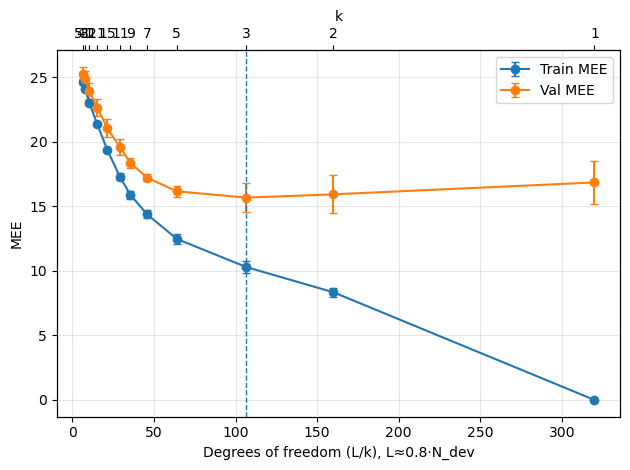

Best k: 3 | Val MEE: 15.685209535341397 | std: 1.134290415434347


In [11]:
# --- assumes: X_dev, y_dev already prepared; y_dev shape (n,4)

neg_mee = make_scorer(lambda yt, yp: np.mean(np.linalg.norm(yt - yp, axis=1)),
                      greater_is_better=False)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
neighbors_grid = np.array([1,2,3,5,7,9,11,15,21,31,41,51], dtype=int)

train_mean, train_std, val_mean, val_std = [], [], [], []

for k in neighbors_grid:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=4, random_state=42)),
        ("knn", KNeighborsRegressor(n_neighbors=k))
    ])
    out = cross_validate(pipe, X_dev, y_dev, scoring=neg_mee, cv=cv,
                         return_train_score=True, n_jobs=-1)

    train_mean.append((-out["train_score"]).mean())
    train_std.append((-out["train_score"]).std())
    val_mean.append((-out["test_score"]).mean())
    val_std.append((-out["test_score"]).std())

train_mean = np.array(train_mean); train_std = np.array(train_std)
val_mean   = np.array(val_mean);   val_std   = np.array(val_std)

# --- DoF ~ L/k, with L ≈ 0.8*N for 5-fold
N = X_dev.shape[0]
L_eff = 0.8 * N
dof = L_eff / neighbors_grid

order = np.argsort(dof)
dof_s = dof[order]
k_s   = neighbors_grid[order]

best_i = int(np.argmin(val_mean))
best_k = int(neighbors_grid[best_i])
best_dof = float(L_eff / best_k)

# --- plot
fig, ax = plt.subplots()
ax.errorbar(dof_s, train_mean[order], yerr=train_std[order], marker="o", capsize=3, label="Train MEE")
ax.errorbar(dof_s, val_mean[order],   yerr=val_std[order],   marker="o", capsize=3, label="Val MEE")
ax.axvline(best_dof, linestyle="--", linewidth=1)

ax.set_xlabel("Degrees of freedom (L/k), L≈0.8·N_dev")
ax.set_ylabel("MEE")
ax.grid(True, alpha=0.3)
ax.legend()

ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(dof_s)
ax_top.set_xticklabels(k_s)
ax_top.set_xlabel("k")

plt.tight_layout()
plt.show()

print("Best k:", best_k, "| Val MEE:", float(val_mean[best_i]), "| std:", float(val_std[best_i]))


In [23]:
# assumes mee already defined above
neg_mee = make_scorer(mee, greater_is_better=False)

param_grid = {
    "knn__n_neighbors": [5, 7, 9, 11, 15, 21, 31, 41, 51],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=4, random_state=42)),
    ("knn", KNeighborsRegressor(metric="minkowski"))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(pipe, param_grid, scoring=neg_mee, cv=cv, refit=True, n_jobs=-1, verbose=1)
gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)

y_pred_internal = gs.best_estimator_.predict(X_test)
print("Internal (20%) MEE:", mee(y_test, y_pred_internal))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}
Best CV MEE: 15.439564621588726
Internal (20%) MEE: 14.376157131290524


In [24]:
# Dự đoán trên tập huấn luyện
y_train_pred = gs.best_estimator_.predict(X_dev)
train_mee = mee(y_dev, y_train_pred)
print("Train MEE:", train_mee)

# Dự đoán trên tập kiểm tra
y_pred_internal = gs.best_estimator_.predict(X_test)
print("Internal (20%) MEE:", mee(y_test, y_pred_internal))

Train MEE: 0.0
Internal (20%) MEE: 14.376157131290524


## Grid search

In [9]:
# assumes mee already defined above
neg_mee = make_scorer(mee, greater_is_better=False)

param_grid = {
    "knn__n_neighbors": [5, 7, 9, 11, 15, 21, 31, 41, 51],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=4, random_state=42)),
    ("knn", KNeighborsRegressor(metric="minkowski"))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(pipe, param_grid, scoring=neg_mee, cv=cv, refit=True, n_jobs=-1, verbose=1)
gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)

y_pred_internal = gs.best_estimator_.predict(X_test)
print("Internal (20%) MEE:", mee(y_test, y_pred_internal))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}
Best CV MEE: 15.439564621588726
Internal (20%) MEE: 14.376157131290524


In [10]:
y_train_pred = gs.best_estimator_.predict(X_dev)
train_mee = mee(y_dev, y_train_pred)
print("Train MEE:", train_mee)

y_pred_internal = gs.best_estimator_.predict(X_test)
print("Internal (20%) MEE:", mee(y_test, y_pred_internal))

Train MEE: 0.0
Internal (20%) MEE: 14.376157131290524


# SVR

In [9]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

base_pipe = make_pipe(MultiOutputRegressor(SVR(kernel="rbf"), n_jobs=1))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import cross_validate

def plot_cv_curve(pipe, X, y, param_name, param_values, fixed_params=None, cv=None):
    if fixed_params is None:
        fixed_params = {}
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)

    train_mean, train_std = [], []
    val_mean, val_std = [], []

    for v in param_values:
        est = clone(pipe).set_params(**fixed_params, **{param_name: v})

        out = cross_validate(
            est, X, y,
            scoring=neg_mee,
            cv=cv,
            return_train_score=True,
            n_jobs=-1
        )

        tr = -out["train_score"]
        va = -out["test_score"]

        train_mean.append(tr.mean()); train_std.append(tr.std())
        val_mean.append(va.mean());   val_std.append(va.std())

    train_mean = np.array(train_mean); train_std = np.array(train_std)
    val_mean   = np.array(val_mean);   val_std   = np.array(val_std)

    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_xscale("log")
    ax.plot(param_values, train_mean, marker="o", label="Train MEE (mean ± std)")
    ax.fill_between(param_values, train_mean-train_std, train_mean+train_std, alpha=0.2)

    ax.plot(param_values, val_mean, marker="o", label="Val MEE (mean ± std)")
    ax.fill_between(param_values, val_mean-val_std, val_mean+val_std, alpha=0.2)

    best_idx = int(np.argmin(val_mean))
    ax.axvline(param_values[best_idx], linestyle="--", linewidth=1)

    ax.set_xlabel(param_name)
    ax.set_ylabel("MEE")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"Best {param_name} = {param_values[best_idx]} | CV Val MEE = {val_mean[best_idx]} | std = {val_std[best_idx]}")
    return param_values[best_idx], val_mean, val_std

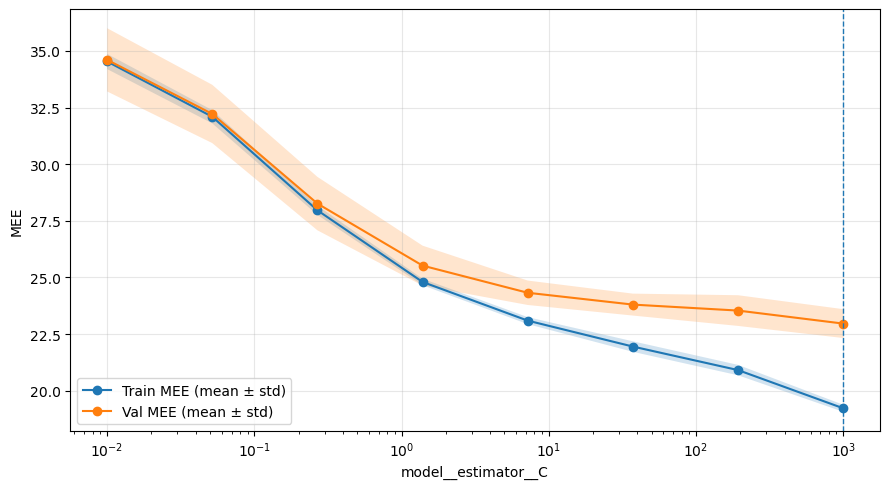

Best model__estimator__C = 1000.0 | CV Val MEE = 22.960343190087606 | std = 0.637127475466528


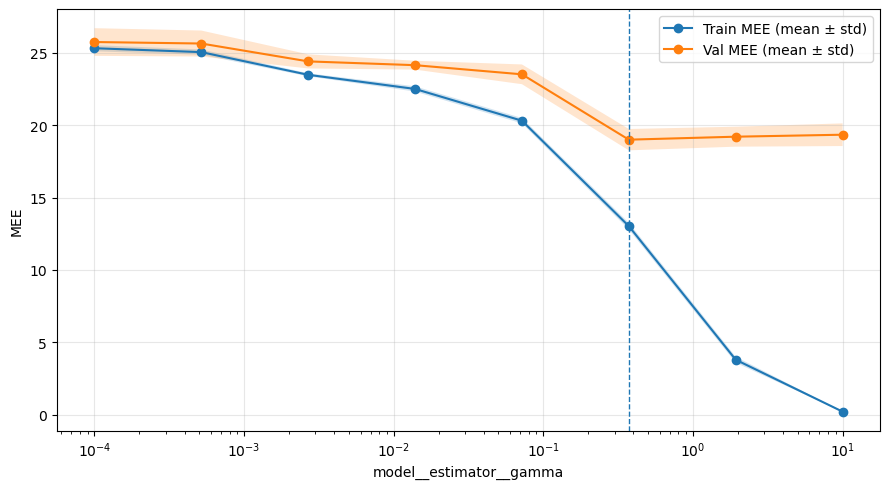

Best model__estimator__gamma = 0.3727593720314942 | CV Val MEE = 19.003476642700104 | std = 0.7375030924994601


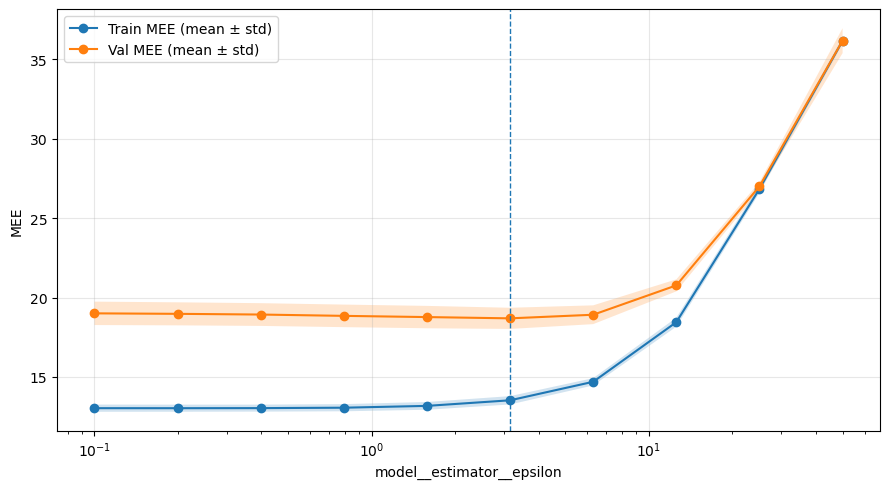

Best model__estimator__epsilon = 3.15811383485066 | CV Val MEE = 18.688605876340254 | std = 0.6667062039801622
Chosen (coarse) params: {'C': 1000.0, 'gamma': 0.3727593720314942, 'epsilon': 3.15811383485066}


In [13]:
C_range   = np.logspace(-2, 3, 8)
gam_range = np.logspace(-4, 1, 8)
eps_range = np.logspace(-1, np.log10(50), 10)

# Tune C (fix gamma, epsilon)
best_C, _, _ = plot_cv_curve(
    base_pipe, X_dev, y_dev,
    param_name="model__estimator__C",
    param_values=C_range,
    fixed_params={"model__estimator__gamma": 0.1, "model__estimator__epsilon": 0.1},
    cv=cv
)

# Tune gamma (fix C, epsilon)
best_g, _, _ = plot_cv_curve(
    base_pipe, X_dev, y_dev,
    param_name="model__estimator__gamma",
    param_values=gam_range,
    fixed_params={"model__estimator__C": float(best_C), "model__estimator__epsilon": 0.1},
    cv=cv
)

# Tune epsilon (fix C, gamma)
best_eps, _, _ = plot_cv_curve(
    base_pipe, X_dev, y_dev,
    param_name="model__estimator__epsilon",
    param_values=eps_range,
    fixed_params={"model__estimator__C": float(best_C), "model__estimator__gamma": float(best_g)},
    cv=cv
)

print("Chosen (coarse) params:", {"C": best_C, "gamma": best_g, "epsilon": best_eps})


## Grid search

In [14]:
param_grid = {
    "model__estimator__gamma":   [0.1, 0.3, 0.37, 0.4, 0.5],
    "model__estimator__C":       [30, 50, 80, 120, 100, 300, 500, 1000],
    "model__estimator__epsilon": [0.3, 0.6, 1.0, 1.5, 2.0, 3.0, 4.0],
}

gs = GridSearchCV(
    estimator=base_pipe,   
    param_grid=param_grid,
    scoring=neg_mee,
    cv=cv,            
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    verbose=1
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best params: {'model__estimator__C': 500, 'model__estimator__epsilon': 2.0, 'model__estimator__gamma': 0.5}
Best CV MEE: 18.21858050320456


In [15]:
y_test_pred = gs.best_estimator_.predict(X_test)

# optional sanity checks
print("y_test:", y_test.shape, "y_pred:", y_test_pred.shape)

test_mee = mee(y_test, y_test_pred)
print("Internal (20%) MEE:", test_mee)

y_test: (100, 4) y_pred: (100, 4)
Internal (20%) MEE: 18.13443812805293


In [17]:
y_pred_train = gs.predict(X_dev)
train_mee = mee(y_dev, y_pred_train)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)
print("Train MEE:", train_mee)

Best params: {'model__estimator__C': 500, 'model__estimator__epsilon': 2.0, 'model__estimator__gamma': 0.5}
Best CV MEE: 18.21858050320456
Train MEE: 13.153922024796065


# XGboost

In [11]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
base_xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=1,
    verbosity=0
)

pipe = make_pipe(MultiOutputRegressor(base_xgb))

base_xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=1,
    verbosity=0
)

In [12]:
best_fixed = {
  "model__estimator__n_estimators": 500,
  "model__estimator__learning_rate": 0.1,
  "model__estimator__max_depth": 4,
  "model__estimator__min_child_weight": 1,
  "model__estimator__subsample": 0.8,
  "model__estimator__colsample_bytree": 1.0,
  "model__estimator__gamma": 0,
  "model__estimator__reg_lambda": 1,
  "model__estimator__reg_alpha": 0,
}


In [13]:
from sklearn.base import clone
from sklearn.model_selection import cross_validate

def plot_cv_curve(pipe, X, y, param_name, param_values, fixed_params=None, cv=None):
    if fixed_params is None:
        fixed_params = {}
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)

    train_mean, train_std, val_mean, val_std = [], [], [], []

    for v in param_values:
        est = clone(pipe)
        params = dict(fixed_params)
        params[param_name] = v      # override sweep param
        est.set_params(**params)

        out = cross_validate(
            est, X, y,
            scoring=neg_mee,
            cv=cv,
            return_train_score=True,
            n_jobs=-1
        )

        tr = -out["train_score"]
        va = -out["test_score"]
        train_mean.append(tr.mean()); train_std.append(tr.std())
        val_mean.append(va.mean());   val_std.append(va.std())

    train_mean = np.array(train_mean); train_std = np.array(train_std)
    val_mean   = np.array(val_mean);   val_std   = np.array(val_std)

    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(param_values, train_mean, marker="o", label="Train MEE (mean ± std)")
    ax.fill_between(param_values, train_mean-train_std, train_mean+train_std, alpha=0.2)
    ax.plot(param_values, val_mean, marker="o", label="Val MEE (mean ± std)")
    ax.fill_between(param_values, val_mean-val_std, val_mean+val_std, alpha=0.2)

    best_idx = int(np.argmin(val_mean))
    ax.axvline(param_values[best_idx], linestyle="--", linewidth=1)

    ax.set_xlabel(param_name)
    ax.set_ylabel("MEE")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"Best {param_name} = {param_values[best_idx]} | CV Val MEE = {val_mean[best_idx]} | std = {val_std[best_idx]}")
    return param_values[best_idx], val_mean, val_std


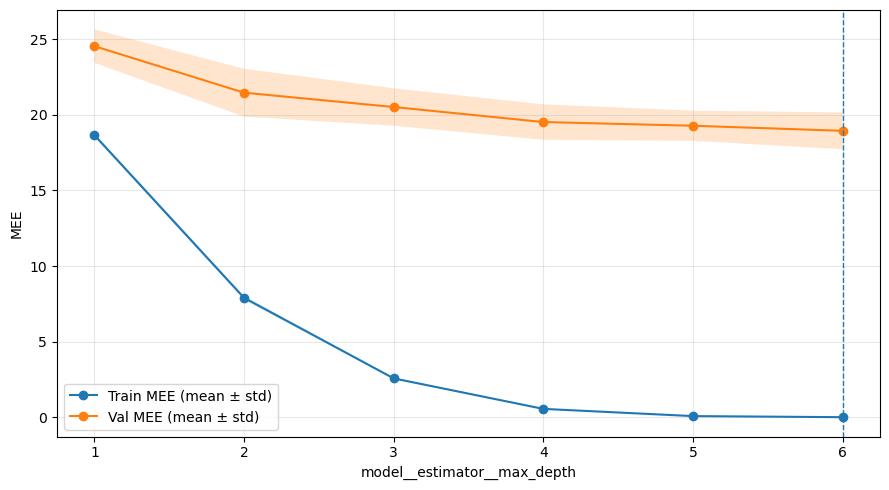

Best model__estimator__max_depth = 6 | CV Val MEE = 18.94714458310616 | std = 1.2176332399830168


In [14]:
depth_range = [1,2,3,4,5,6]

best_depth, _, _ = plot_cv_curve(
    pipe, X_dev, y_dev,
    param_name="model__estimator__max_depth",
    param_values=depth_range,
    fixed_params=best_fixed,
    cv=cv
)

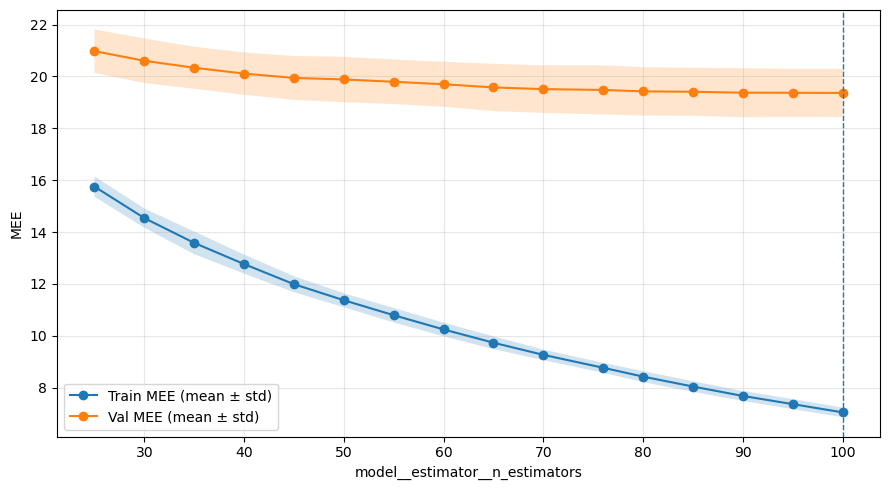

Best model__estimator__n_estimators = 100 | CV Val MEE = 19.36559770967549 | std = 0.9310476113213487


In [33]:
n_range = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 76, 80, 85, 90, 95, 100]

best_n, _, _ = plot_cv_curve(
    pipe, X_dev, y_dev,
    param_name="model__estimator__n_estimators",
    param_values=n_range,
    fixed_params=best_fixed,
    cv=cv
)


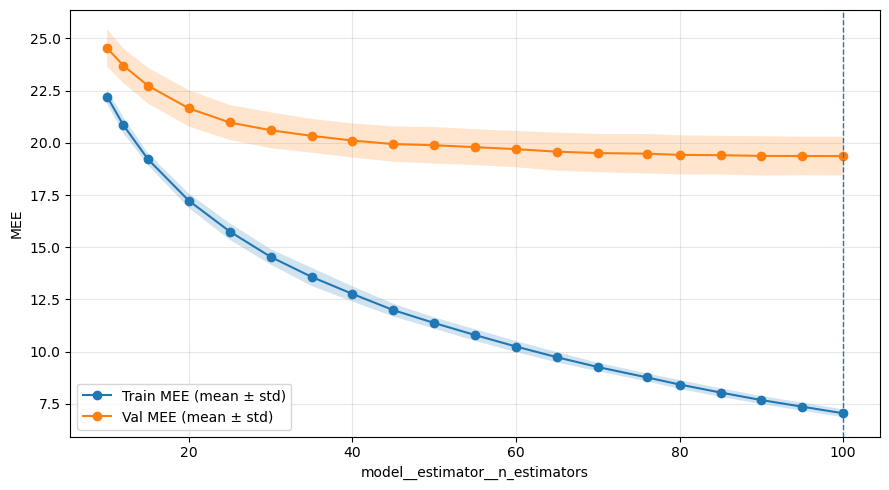

Best model__estimator__n_estimators = 100 | CV Val MEE = 19.36559770967549 | std = 0.9310476113213487


In [34]:
n_range = [10, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 76, 80, 85, 90, 95, 100]

best_n, _, _ = plot_cv_curve(
    pipe, X_dev, y_dev,
    param_name="model__estimator__n_estimators",
    param_values=n_range,
    fixed_params=best_fixed,
    cv=cv
)


range 10, 12, 15, 20, 60, 80, 100

### min_child_weight

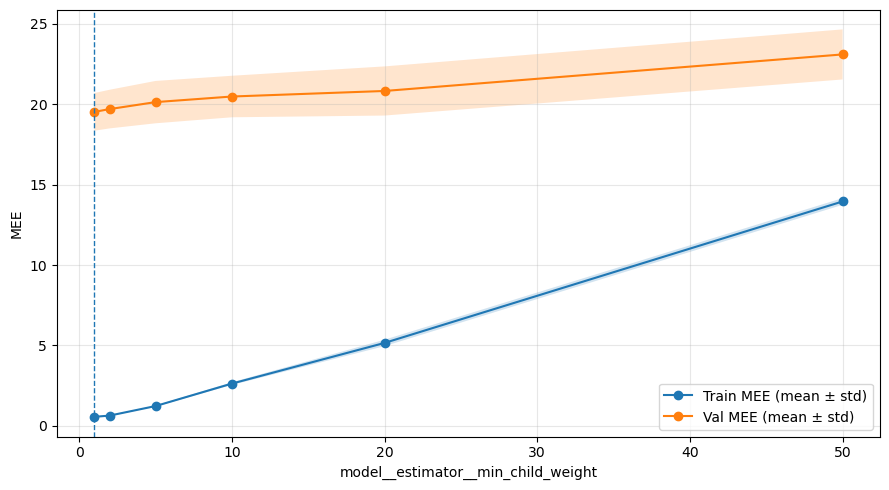

Best model__estimator__min_child_weight = 1 | CV Val MEE = 19.528019562947073 | std = 1.1724616028347095


In [42]:
mcw_range = [1, 2, 5, 10, 20, 50]

best_mcw, _, _ = plot_cv_curve(
    pipe, X_dev, y_dev,
    param_name="model__estimator__min_child_weight",
    param_values=mcw_range,
    fixed_params=best_fixed,
    cv=cv
)


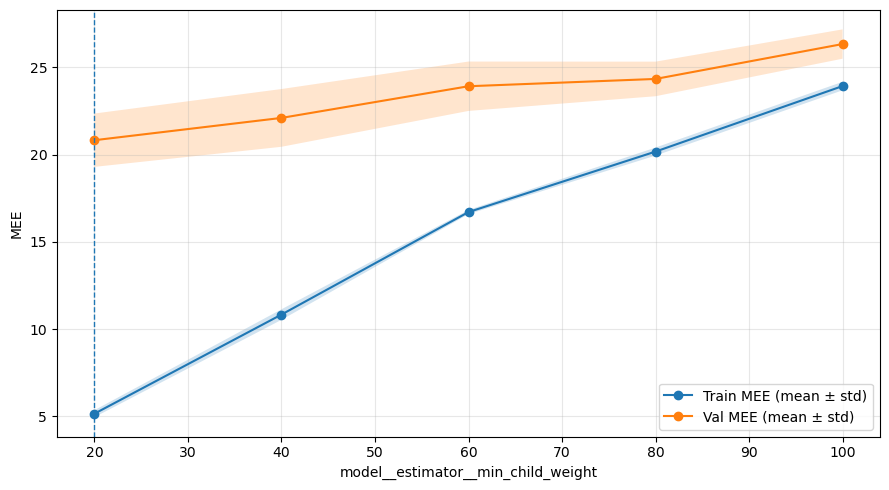

Best model__estimator__min_child_weight = 20 | CV Val MEE = 20.82828618058624 | std = 1.5288049075027001


In [43]:
mcw_range = [20, 40, 60, 80, 100]

best_mcw, _, _ = plot_cv_curve(
    pipe, X_dev, y_dev,
    param_name="model__estimator__min_child_weight",
    param_values=mcw_range,
    fixed_params=best_fixed,
    cv=cv
)


### gamma

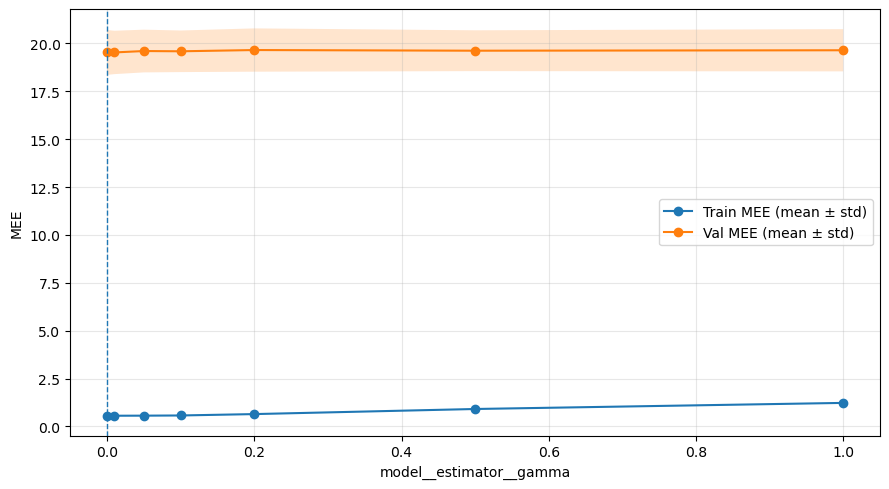

Best model__estimator__gamma = 0 | CV Val MEE = 19.528019562947073 | std = 1.1724616028347095


In [44]:
best_gamma, _, _ = plot_cv_curve(
    pipe, X_dev, y_dev,
    param_name="model__estimator__gamma",
    param_values=[0,0.01,0.05,0.1,0.2,0.5,1.0],
    fixed_params=best_fixed,
    cv=cv
)

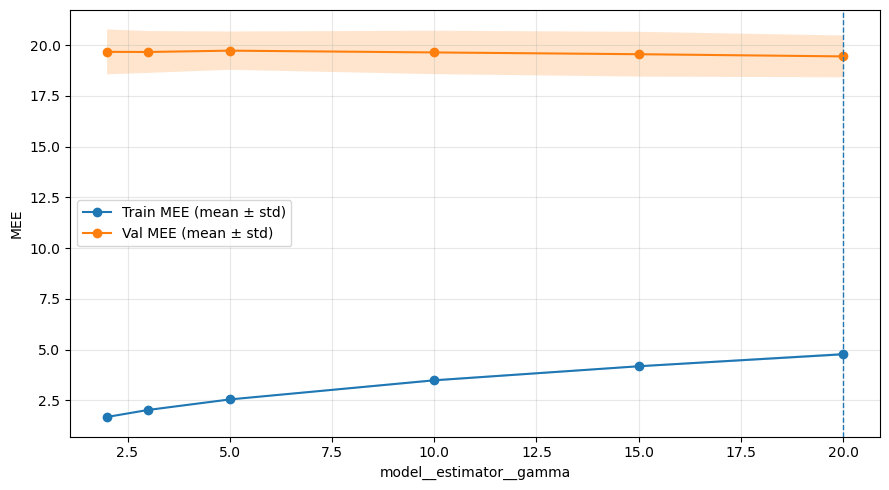

Best model__estimator__gamma = 20 | CV Val MEE = 19.44925832407042 | std = 1.0307443346372918


In [45]:
best_gamma, _, _ = plot_cv_curve(
    pipe, X_dev, y_dev,
    param_name="model__estimator__gamma",
    param_values=[2, 3, 5, 10, 15, 20],
    fixed_params=best_fixed,
    cv=cv
)

In our plot: Val MEE is almost flat (~19.4–20) despite strong gamma variation. This generally suggests that:
gamma is not the knob determining generalization in the current pipeline,
so we should focus on the "stronger" knobs: max_depth, min_child_weight, subsample, colsample_bytree.

### final tuning

In [49]:
param_grid_refine = {
    "model__estimator__max_depth":        [4, 5, 6],
    "model__estimator__n_estimators":     [60, 80],
    "model__estimator__min_child_weight": [5, 10, 20],
    "model__estimator__subsample":        [0.8, 1],
    "model__estimator__colsample_bytree": [0.8, 1.0],
    "model__estimator__gamma":            [0.5, 0.2],
    "model__estimator__reg_lambda":       [0.5, 2, 5, 10],
    "model__estimator__reg_alpha":        [0.2, 0.05, 0.1],
    "model__estimator__learning_rate":    [0.05, 0.1],
}


In [50]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_refine,
    scoring=neg_mee,
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)

y_pred_internal = gs.best_estimator_.predict(X_test)
print("Internal (20%) MEE:", mee(y_test, y_pred_internal))

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
Best params: {'model__estimator__colsample_bytree': 1.0, 'model__estimator__gamma': 0.2, 'model__estimator__learning_rate': 0.1, 'model__estimator__max_depth': 6, 'model__estimator__min_child_weight': 5, 'model__estimator__n_estimators': 80, 'model__estimator__reg_alpha': 0.2, 'model__estimator__reg_lambda': 0.5, 'model__estimator__subsample': 1}
Best CV MEE: 18.942998686051673
Internal (20%) MEE: 17.56358159589905


In [19]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

xgb_best = XGBRegressor(
    colsample_bytree=1.0,
    gamma=0.2,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=5,
    n_estimators=80,
    reg_alpha=0.2,
    reg_lambda=0.5,
    subsample=1,
    verbosity=0,
    n_jobs=-1
)

multi_output_model = MultiOutputRegressor(xgb_best, n_jobs=-1)

pipe_best = make_pipe(multi_output_model)


In [20]:
pipe_best.fit(X_dev, y_dev)

y_pred_train = pipe_best.predict(X_dev)
y_pred_test = pipe_best.predict(X_test)

print("Train MEE:", mee(y_dev, y_pred_train))
print("Internal (20%) MEE:", mee(y_test, y_pred_test))


Train MEE: 5.617750471521072
Internal (20%) MEE: 17.56358159589905


OVERFITTING

## final tuning 2

In [21]:
param_grid_refine = {
    "model__estimator__max_depth":        [1, 2],
    "model__estimator__n_estimators":     [20, 30],
    "model__estimator__min_child_weight": [30, 20],
    "model__estimator__subsample":        [0.8, 1],
    "model__estimator__colsample_bytree": [0.8, 1.0],
    "model__estimator__gamma":            [0.5, 0.2],
    "model__estimator__reg_lambda":       [0.5, 2, 5, 10],
    "model__estimator__reg_alpha":        [0.2, 0.05, 0.1],
    "model__estimator__learning_rate":    [0.05, 0.1],
}

In [24]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_refine,
    scoring=neg_mee,
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)

y_pred_internal = gs.best_estimator_.predict(X_test)
print("Internal (20%) MEE:", mee(y_test, y_pred_internal))

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
Best params: {'model__estimator__colsample_bytree': 1.0, 'model__estimator__gamma': 0.5, 'model__estimator__learning_rate': 0.1, 'model__estimator__max_depth': 2, 'model__estimator__min_child_weight': 20, 'model__estimator__n_estimators': 30, 'model__estimator__reg_alpha': 0.2, 'model__estimator__reg_lambda': 0.5, 'model__estimator__subsample': 1}
Best CV MEE: 23.829960579613214
Internal (20%) MEE: 23.801049337780213


In [26]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
xgb_best = XGBRegressor(
    colsample_bytree=1.0,
    gamma=0.5,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=20,
    n_estimators=30,
    reg_alpha=0.2,
    reg_lambda=0.5,
    subsample=1,
    verbosity=0,
    n_jobs=-1
)

multi_output_model = MultiOutputRegressor(xgb_best, n_jobs=-1)
pipe_best = make_pipe(multi_output_model)

In [27]:
pipe_best.fit(X_dev, y_dev)

y_pred_train = pipe_best.predict(X_dev)
y_pred_test = pipe_best.predict(X_test)

print("Train MEE:", mee(y_dev, y_pred_train))
print("Internal (20%) MEE:", mee(y_test, y_pred_test))

Train MEE: 21.7833581832908
Internal (20%) MEE: 23.801049337780213


## tuning 3

In [13]:
param_grid_refine = {
    "model__estimator__max_depth":        [1, 2],
    "model__estimator__n_estimators":     [20, 30],
    "model__estimator__min_child_weight": [30, 20]}

In [14]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_refine,
    scoring=neg_mee,
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_dev, y_dev)

print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)

y_pred_internal = gs.best_estimator_.predict(X_test)
print("Internal (20%) MEE:", mee(y_test, y_pred_internal))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'model__estimator__max_depth': 2, 'model__estimator__min_child_weight': 20, 'model__estimator__n_estimators': 30}
Best CV MEE: 22.810484206742522
Internal (20%) MEE: 22.04017278734743


In [15]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

xgb_best = XGBRegressor(
    max_depth=2,
    min_child_weight=20,
    n_estimators=30
)

multi_output_model = MultiOutputRegressor(xgb_best, n_jobs=-1)
pipe_best = make_pipe(multi_output_model)

In [16]:
pipe_best.fit(X_dev, y_dev)

y_pred_train = pipe_best.predict(X_dev)
y_pred_test = pipe_best.predict(X_test)

print("Train MEE:", mee(y_dev, y_pred_train))
print("Internal (20%) MEE:", mee(y_test, y_pred_test))

Train MEE: 17.948614942945678
Internal (20%) MEE: 22.04017278734743


# Random Forrest

## no pca + scaler

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import KFold, cross_validate

def plot_cv_curve_rf(
    pipe, X, y,
    param_name,
    param_values,
    fixed_params=None,
    cv=None,
    scoring=None,          # ví dụ: neg_mee
    n_jobs=-1,
    log_x=False,           # RF thường để False
    rotate_xticks=0
):
    """
    Plot Train vs CV curve (mean±std) for RandomForest-style hyperparameters.
    Supports param_values containing ints/floats/None/strings.
    """

    if fixed_params is None:
        fixed_params = {}
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    if scoring is None:
        raise ValueError("Please pass scoring (e.g., neg_mee).")

    # Decide x-axis strategy
    def _is_number(v):
        return isinstance(v, (int, float, np.integer, np.floating))

    all_numeric = all(_is_number(v) for v in param_values)
    any_none = any(v is None for v in param_values)

    if all_numeric and not any_none:
        x = np.array(param_values, dtype=float)
        x_labels = None
        use_positions = False
    else:
        # Use categorical positions
        x = np.arange(len(param_values), dtype=float)
        x_labels = ["None" if v is None else str(v) for v in param_values]
        use_positions = True
        log_x = False  # categorical => no log

    train_mean, train_std, val_mean, val_std = [], [], [], []

    for v in param_values:
        est = clone(pipe)
        params = dict(fixed_params)
        params[param_name] = v
        est.set_params(**params)

        out = cross_validate(
            est, X, y,
            scoring=scoring,
            cv=cv,
            return_train_score=True,
            n_jobs=n_jobs
        )

        tr = -out["train_score"]
        va = -out["test_score"]
        train_mean.append(tr.mean()); train_std.append(tr.std())
        val_mean.append(va.mean());   val_std.append(va.std())

    train_mean = np.asarray(train_mean)
    train_std  = np.asarray(train_std)
    val_mean   = np.asarray(val_mean)
    val_std    = np.asarray(val_std)

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))

    if log_x and not use_positions:
        ax.set_xscale("log")

    ax.plot(x, train_mean, marker="o", label="Train MEE (mean ± std)")
    ax.fill_between(x, train_mean - train_std, train_mean + train_std, alpha=0.2)

    ax.plot(x, val_mean, marker="o", label="CV MEE (mean ± std)")
    ax.fill_between(x, val_mean - val_std, val_mean + val_std, alpha=0.2)

    best_idx = int(np.argmin(val_mean))
    ax.axvline(x[best_idx], linestyle="--", linewidth=1)

    ax.set_xlabel(param_name)
    ax.set_ylabel("MEE")
    ax.grid(True, alpha=0.3)
    ax.legend()

    if use_positions:
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=rotate_xticks)

    plt.tight_layout()
    plt.show()

    best_value = param_values[best_idx]
    print(
        f"Best {param_name} = {best_value} | "
        f"CV Val MEE = {val_mean[best_idx]:.6f} | std = {val_std[best_idx]:.6f}"
    )

    return best_value, val_mean, val_std


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

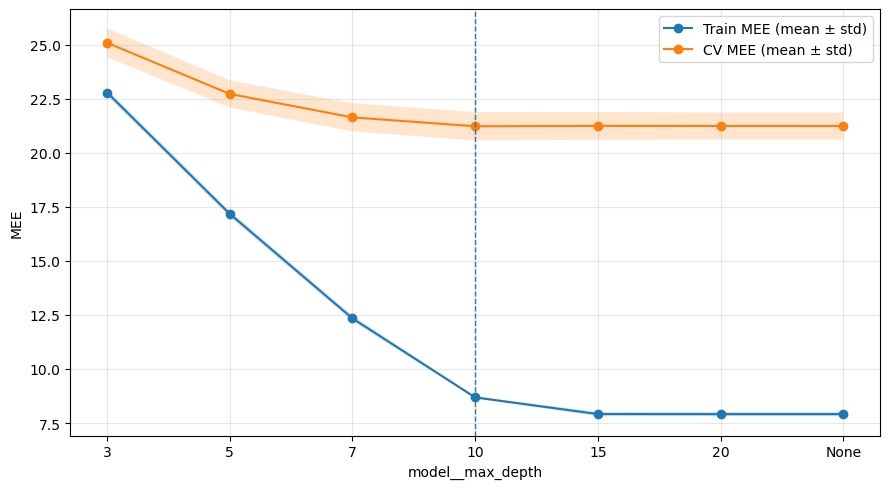

Best model__max_depth = 10 | CV Val MEE = 21.231191 | std = 0.654363


In [32]:
depth_range = [3, 5, 7, 10, 15, 20, None]

best_depth, _, _ = plot_cv_curve_rf(
    pipe_rf, X_dev, y_dev,
    param_name="model__max_depth",         
    param_values=depth_range,
    fixed_params={"model__n_estimators": 300, "model__random_state": 42},
    cv=cv,
    scoring=neg_mee
)

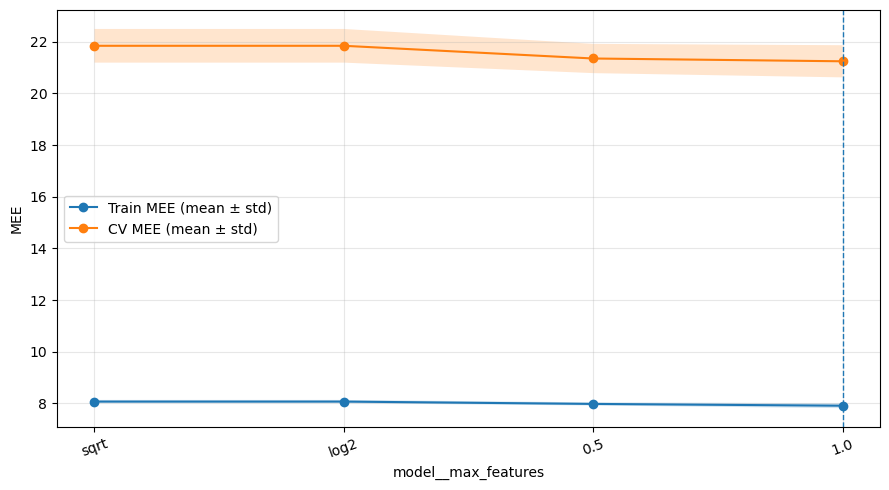

Best model__max_features = 1.0 | CV Val MEE = 21.243762 | std = 0.622503


In [33]:
feat_range = ["sqrt", "log2", 0.5, 1.0]

best_feat, _, _ = plot_cv_curve_rf(
    pipe_rf, X_dev, y_dev,
    param_name="model__max_features",
    param_values=feat_range,
    fixed_params={"model__n_estimators": 300, "model__random_state": 42},
    cv=cv,
    scoring=neg_mee,
    rotate_xticks=20
)

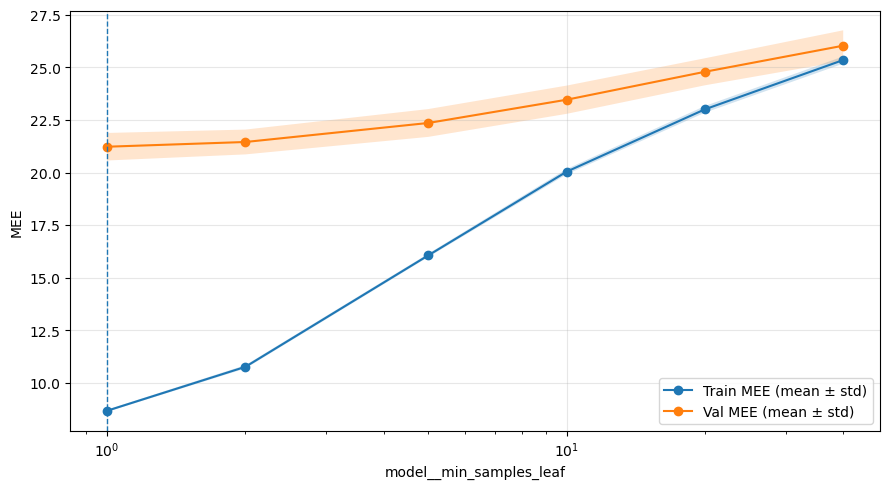

Best model__min_samples_leaf = 1 | CV Val MEE = 21.23119100348357 | std = 0.6543630401010045


In [34]:
leaf_range = [1, 2, 5, 10, 20, 40]

best_leaf, _, _ = plot_cv_curve(
    pipe_rf, X_dev, y_dev,
    param_name="model__min_samples_leaf",
    param_values=leaf_range,
    fixed_params={
        "model__n_estimators": 300,
        "model__max_depth": int(best_depth)
    },
    cv=cv
)


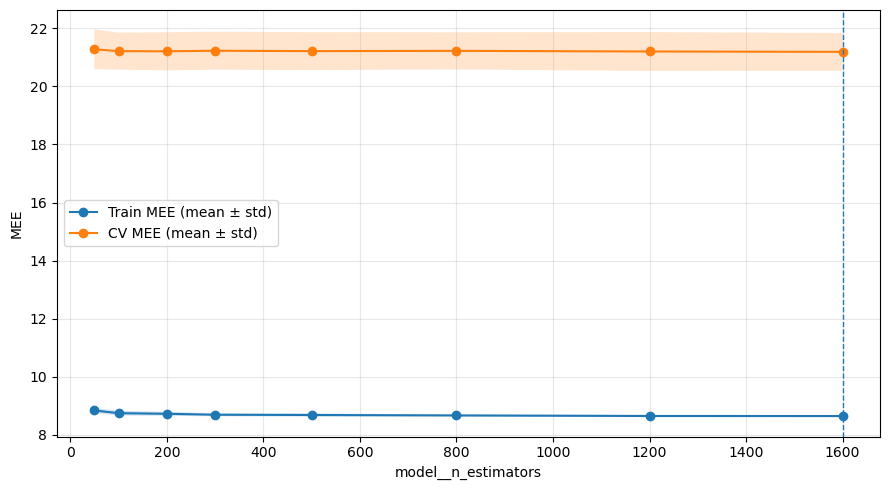

Best model__n_estimators = 1600 | CV Val MEE = 21.192817 | std = 0.649487
Best n_estimators: 1600


In [13]:
n_est_range = [50, 100, 200, 300, 500, 800, 1200, 1600]

best_n, _, _ = plot_cv_curve_rf(
    pipe_rf, X_dev, y_dev,
    param_name="model__n_estimators",
    param_values=n_est_range,
    fixed_params={
        "model__max_depth": 10,        # hoặc best_depth bạn đã tìm được
        "model__random_state": 42,
        # các params bạn muốn cố định thêm:
        # "model__min_samples_leaf": 2,
        # "model__max_features": 0.7,
        # "model__bootstrap": True,
    },
    cv=cv,
    scoring=neg_mee,
    log_x=False   # để False vì dải không quá rộng; nếu bạn dùng [50,100,200,400,...] có thể set True
)

print("Best n_estimators:", best_n)

In [35]:
from sklearn.base import clone
from sklearn.model_selection import cross_validate

est_none = clone(pipe_rf).set_params(
    model__n_estimators=300,
    model__max_depth=None,
    model__min_samples_leaf=int(best_leaf),
    model__max_features=float(best_feat),
)

out = cross_validate(est_none, X_dev, y_dev, scoring=neg_mee, cv=cv, return_train_score=True, n_jobs=-1)
print("CV MEE (max_depth=None):", (-out["test_score"]).mean())


CV MEE (max_depth=None): 21.243762436367373


## Grid search 1

In [11]:
param_grid_rf = [
  {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5, 7, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [0.5, 1.0],
    "model__bootstrap": [True],
    "model__max_samples": [0.8],
  }
]


In [12]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring=neg_mee,
    cv=cv,
    refit=True,                 
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_dev, y_dev)

# ----- Best params + Best CV -----
best_params = gs.best_params_
best_cv_mee = -gs.best_score_

print("Best params:", best_params)
print("Best CV MEE:", best_cv_mee)

# ----- CV Train MEE at best params (mean across folds) -----
best_idx = gs.best_index_
cv_train_mee = -gs.cv_results_["mean_train_score"][best_idx]
cv_train_std = gs.cv_results_["std_train_score"][best_idx]

cv_val_std = gs.cv_results_["std_test_score"][best_idx]

print(f"CV Train MEE (mean±std at best): {cv_train_mee:.6f} ± {cv_train_std:.6f}")
print(f"CV Val   MEE (mean±std at best): {best_cv_mee:.6f} ± {cv_val_std:.6f}")

# ----- Refit Train MEE (on full X_dev after refit) -----
y_pred_train_refit = gs.predict(X_dev)
train_mee_refit = mee(y_dev, y_pred_train_refit)

print("Refit Train MEE (on full X_dev):", train_mee_refit)

y_pred_internal = gs.predict(X_test)
print("Internal Test MEE:", mee(y_test, y_pred_internal))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 1.0, 'model__max_samples': 0.8, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
Best CV MEE: 21.490186641542998
CV Train MEE (mean±std at best): 10.288307 ± 0.088373
CV Val   MEE (mean±std at best): 21.490187 ± 0.661880
Refit Train MEE (on full X_dev): 10.189255786093259
Internal Test MEE: 20.804701502916387


### OVerfitting => decrease max depth

## Grid search 2

In [17]:
param_grid_rf = [
  {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5, 7],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [0.5, 1.0],
    "model__bootstrap": [True],
    "model__max_samples": [0.8],
  }
]


In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring=neg_mee,
    cv=cv,
    refit=True,                 
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_dev, y_dev)

# ----- Best params + Best CV -----
best_params = gs.best_params_
best_cv_mee = -gs.best_score_

print("Best params:", best_params)
print("Best CV MEE:", best_cv_mee)

# ----- CV Train MEE at best params (mean across folds) -----
best_idx = gs.best_index_
cv_train_mee = -gs.cv_results_["mean_train_score"][best_idx]
cv_train_std = gs.cv_results_["std_train_score"][best_idx]

cv_val_std = gs.cv_results_["std_test_score"][best_idx]

print(f"CV Train MEE (mean±std at best): {cv_train_mee:.6f} ± {cv_train_std:.6f}")
print(f"CV Val   MEE (mean±std at best): {best_cv_mee:.6f} ± {cv_val_std:.6f}")

# ----- Refit Train MEE (on full X_dev after refit) -----
y_pred_train_refit = gs.predict(X_dev)
train_mee_refit = mee(y_dev, y_pred_train_refit)

print("Refit Train MEE (on full X_dev):", train_mee_refit)
y_pred_internal = gs.predict(X_test)
print("Internal Test MEE:", mee(y_test, y_pred_internal))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'model__bootstrap': True, 'model__max_depth': 7, 'model__max_features': 1.0, 'model__max_samples': 0.8, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
Best CV MEE: 21.890949510188136
CV Train MEE (mean±std at best): 13.271266 ± 0.072410
CV Val   MEE (mean±std at best): 21.890950 ± 0.611144
Refit Train MEE (on full X_dev): 13.621682682266785
Internal Test MEE: 21.32002072124538


### Overfitting => decrease max depth

## Grid search 3

In [21]:
param_grid_rf = [
  {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [0.5, 1.0],
    "model__bootstrap": [True],
    "model__max_samples": [0.8],
  }
]


In [22]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring=neg_mee,
    cv=cv,
    refit=True,               
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_dev, y_dev)

# ----- Best params + Best CV -----
best_params = gs.best_params_
best_cv_mee = -gs.best_score_

print("Best params:", best_params)
print("Best CV MEE:", best_cv_mee)

# ----- CV Train MEE at best params (mean across folds) -----
best_idx = gs.best_index_
cv_train_mee = -gs.cv_results_["mean_train_score"][best_idx]
cv_train_std = gs.cv_results_["std_train_score"][best_idx]

cv_val_std = gs.cv_results_["std_test_score"][best_idx]

print(f"CV Train MEE (mean±std at best): {cv_train_mee:.6f} ± {cv_train_std:.6f}")
print(f"CV Val   MEE (mean±std at best): {best_cv_mee:.6f} ± {cv_val_std:.6f}")

# ----- Refit Train MEE (on full X_dev after refit) -----
y_pred_train_refit = gs.predict(X_dev)
train_mee_refit = mee(y_dev, y_pred_train_refit)

print("Refit Train MEE (on full X_dev):", train_mee_refit)
y_pred_internal = gs.predict(X_test)
print("Internal Test MEE:", mee(y_test, y_pred_internal))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__bootstrap': True, 'model__max_depth': 5, 'model__max_features': 1.0, 'model__max_samples': 0.8, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
Best CV MEE: 22.87641168490178
CV Train MEE (mean±std at best): 17.561318 ± 0.081635
CV Val   MEE (mean±std at best): 22.876412 ± 0.632278
Refit Train MEE (on full X_dev): 17.96738710363215
Internal Test MEE: 22.53255513030977
